In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-28,221.529999,223.800003,217.199997,219.740005,219.740005,3782500
1,2016-12-29,218.559998,219.199997,214.119995,214.679993,214.679993,4035900
2,2016-12-30,216.300003,217.500000,211.679993,213.690002,213.690002,4642600
3,2017-01-03,214.860001,220.330002,210.960007,216.990005,216.990005,5923300
4,2017-01-04,214.750000,228.000000,214.309998,226.990005,226.990005,11213500


In [3]:
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return buffer

In [4]:
signal = df.Close.values
ma_7 = moving_average(signal, 7)
ma_14 = moving_average(signal, 14)
ma_21 = moving_average(signal, 21)
ma_30 = moving_average(signal, 30)

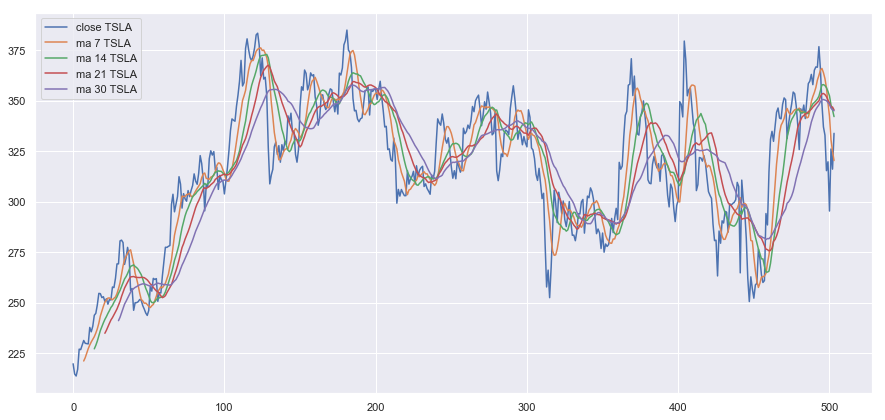

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(len(df.Close)), signal, label ='close TSLA')
plt.plot(np.arange(len(df.Close)), ma_7, label = 'ma 7 TSLA')
plt.plot(np.arange(len(df.Close)), ma_14, label = 'ma 14 TSLA')
plt.plot(np.arange(len(df.Close)), ma_21, label = 'ma 21 TSLA')
plt.plot(np.arange(len(df.Close)), ma_30, label = 'ma 30 TSLA')
plt.legend()
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


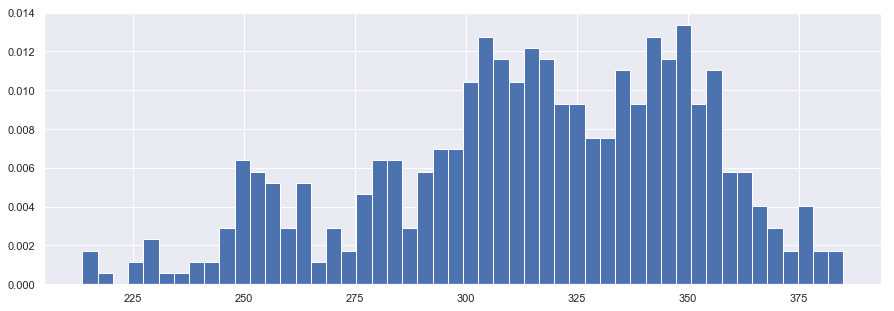

In [6]:
plt.figure(figsize=(15, 5))
plt.hist(df.Close, bins=50, normed=True)
plt.show()

In [7]:
from scipy.stats import skewnorm, norm, gamma

In [8]:
def prior(x):
    if any([val <= 0 for val in x]):
        return 1e-7
    return 1

transition_model_norm = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))]
transition_model_gamma = lambda x: np.random.normal(x,[0.05,5],(2,))

def log_norm(x, data):
    return np.sum(np.log(norm(x[0],x[1]).pdf(data)))

def log_skewnorm(x, data):
    return np.sum(np.log(skewnorm(x[0],x[1]).pdf(data)))

def log_gamma(x, data):
    return np.sum(np.log(gamma(a=x[0],scale=x[1],loc=0).pdf(data)))

def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0, 1)
        return accept < (np.exp(x_new - x))

In [9]:
def metropolis_hastings(pdf, trans_model, param_init, iterations, data):
    x = param_init
    accepted = []
    rejected = []
    for i in range(iterations):
        if (i + 1) % 2000 == 0:
            print(i + 1)
        x_new = trans_model(x)
        x_likehood = pdf(x,data)
        x_new_likehood = pdf(x_new,data)
        x_likehood_prior = x_likehood + np.log(prior(x))
        x_new_likehood_prior = x_new_likehood + np.log(prior(x_new))
        if acceptance(x_likehood_prior, x_new_likehood_prior):
            x = x_new
            accepted.append(x)
        else:
            rejected.append(x_new)
    
    return np.array(accepted), np.array(rejected)    

In [10]:
accepted, rejected = metropolis_hastings(log_norm,
                                         transition_model_norm,
                                         [df.Close.mean(),df.Close.std()], 50000, df.Close)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000


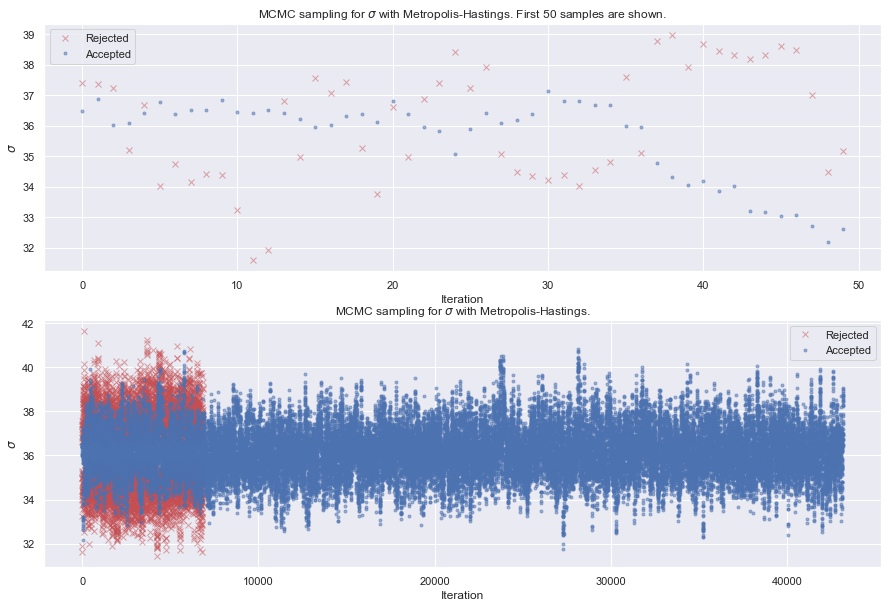

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
plt.plot(accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
plt.xlabel("Iteration")
plt.ylabel("$\sigma$")
plt.title("MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(rejected[-accepted.shape[0]:,1], 'rx', label='Rejected',alpha=0.5)
plt.plot(accepted[-accepted.shape[0]:,1], 'b.', label='Accepted',alpha=0.5)
plt.xlabel("Iteration")
plt.ylabel("$\sigma$")
plt.title("MCMC sampling for $\sigma$ with Metropolis-Hastings.")
plt.legend()

plt.show()

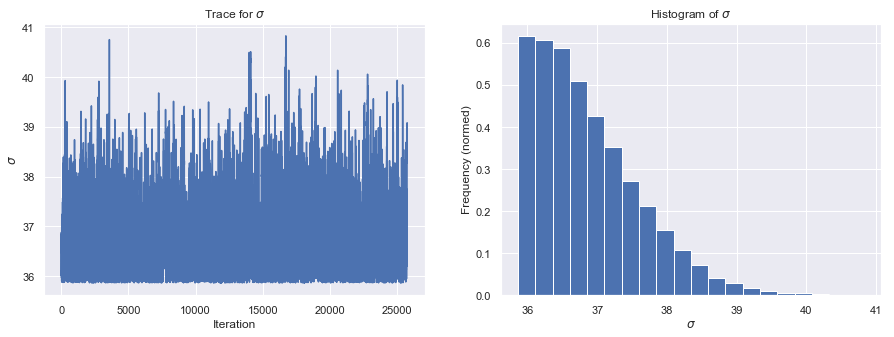

In [12]:
sigmas = accepted[:,1]
sigmas_accept = sigmas.mean() - 0.3

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(sigmas[sigmas > sigmas_accept])
ax.set_title("Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(sigmas[sigmas > sigmas_accept], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Histogram of $\sigma$")
plt.show()

315.1854964047619 36.862993418058196


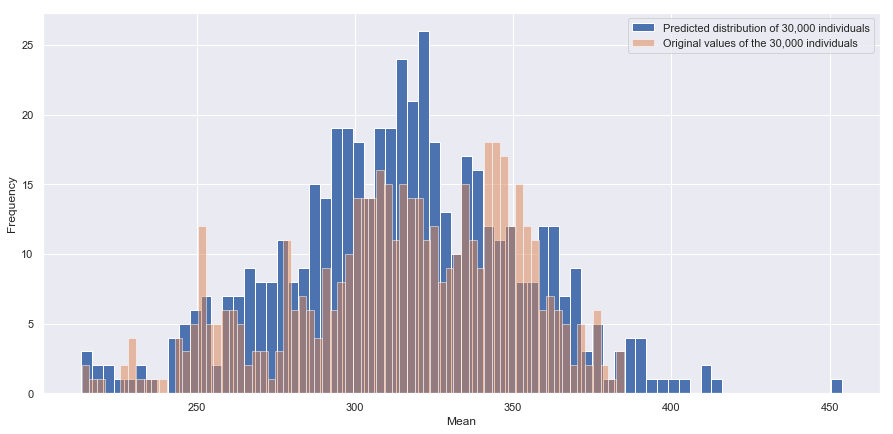

In [13]:
mu=accepted[sigmas > sigmas_accept,0].mean()
sigma=accepted[sigmas > sigmas_accept,1].mean()
print(mu,sigma)
observation_gen = np.random.normal(mu,sigma,df.Close.shape[0])
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.hist(observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist(df.Close,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

In [28]:
def pct_change(x,period=1):
    x = np.array(x)
    return ((x[period:] - x[:-period]) / x[:-period])

In [34]:
number_simulation = 100
predict_day = 30
results = pd.DataFrame()

for i in range(number_simulation):
    prices = df.Close.values[-predict_day:].tolist()
    volatility = pct_change(prices[-predict_day:]).std()
    for d in range(predict_day):
        prices.append(np.random.normal(mu, sigma) * (1 + np.random.normal(0, volatility)))
        volatility = pct_change(prices[-predict_day:]).std()
    results[i] = pd.Series(prices[-predict_day:]).values

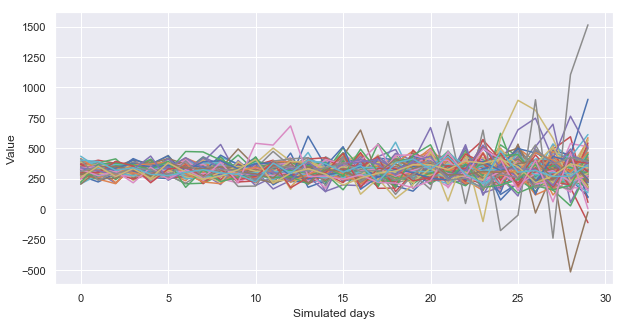

In [35]:
plt.figure(figsize=(10,5))
plt.plot(results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


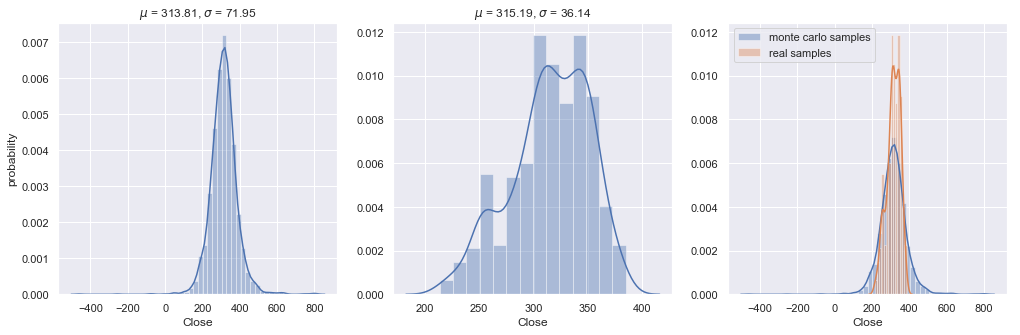

In [30]:
raveled = results.values.ravel()
raveled.sort()
cp_raveled = raveled.copy()

plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
sns.distplot(raveled,norm_hist=True)
plt.xlabel('Close')
plt.ylabel('probability')
plt.title('$\mu$ = %.2f, $\sigma$ = %.2f'%(raveled.mean(),raveled.std()))
plt.subplot(1,3,2)
sns.distplot(df.Close,norm_hist=True)
plt.title('$\mu$ = %.2f, $\sigma$ = %.2f'%(df.Close.mean(),df.Close.std()))
plt.subplot(1,3,3)
sns.distplot(raveled,norm_hist=True,label='monte carlo samples')
sns.distplot(df.Close,norm_hist=True,label='real samples')
plt.legend()
plt.show()

In [36]:
accepted, rejected = metropolis_hastings(log_gamma,
                                         transition_model_gamma,
                                         [5, 10], 50000, df.Close)

2000
4000
6000
8000
10000
12000


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000


Text(0.5, 1.0, 'MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

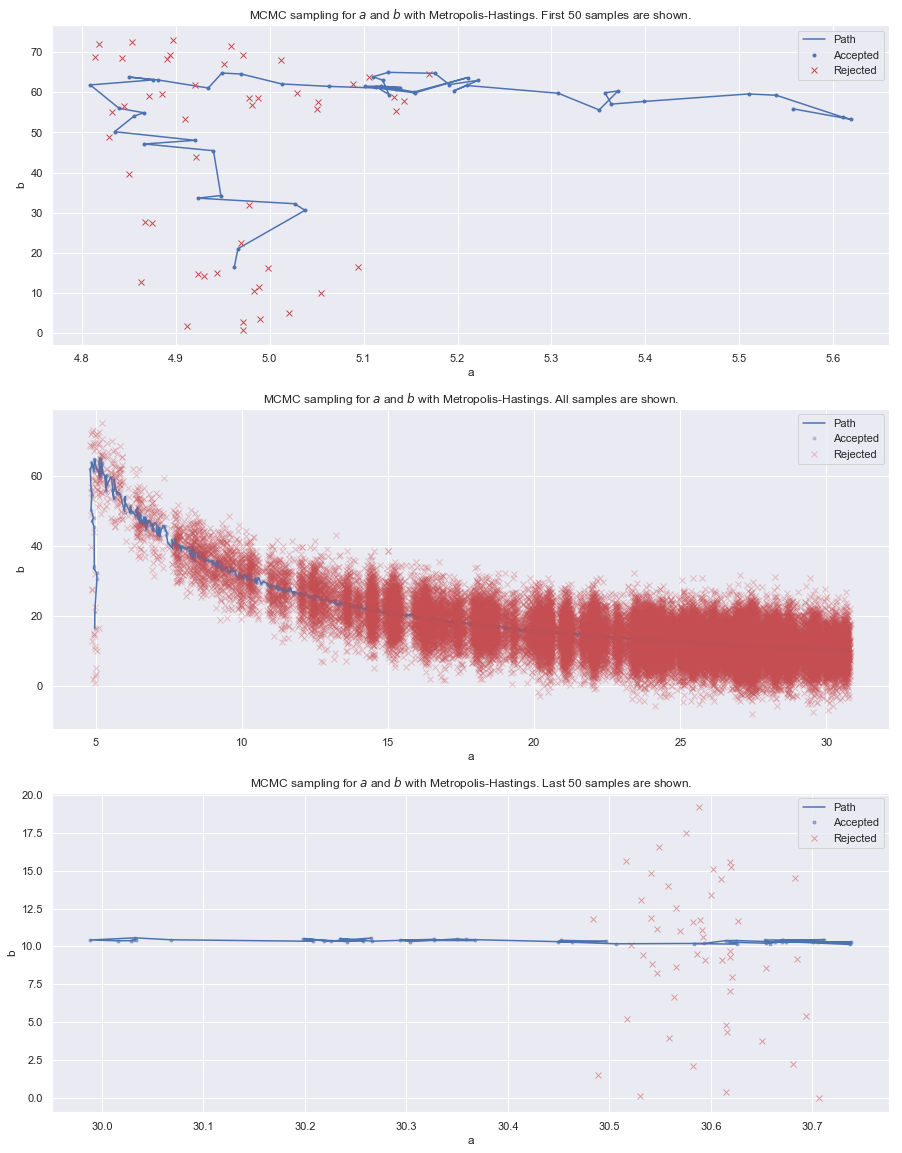

In [37]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.")

16.53491969334702 19.247786826236318


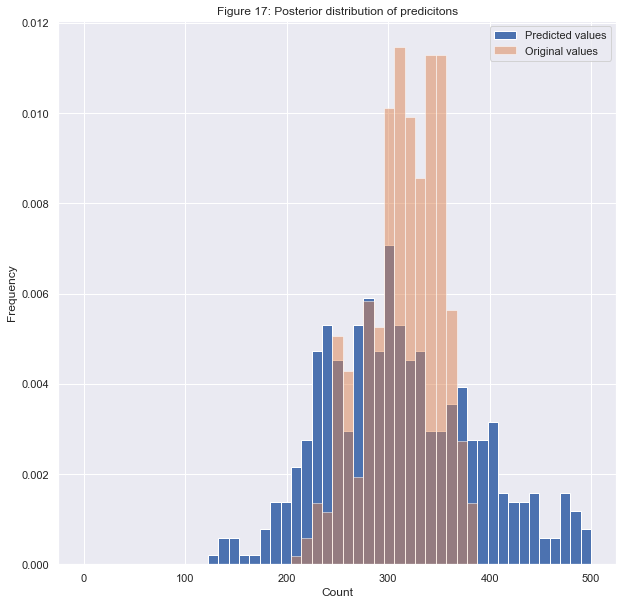

In [76]:
masking = (sigmas > (sigmas.mean() - (sigmas.mean() * 0.2))) & (sigmas < (sigmas.mean() + (sigmas.mean() * 0.2)))
mu=accepted[masking,0].mean()
sigma=accepted[masking,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.gamma(mu,sigma,t)
t=np.arange(df.Close.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)


ax.hist(observation_gen,bins=np.linspace(0,500,50) ,normed=True,label="Predicted values")
ax.hist(df.Close,bins=np.linspace(0,500,50) ,alpha=0.5,normed=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 17: Posterior distribution of predicitons")
ax.legend()
plt.show()

In [77]:
for i in range(number_simulation):
    prices = df.Close.values[-predict_day:].tolist()
    volatility = pct_change(prices[-predict_day:]).std()
    for d in range(predict_day):
        prices.append(np.random.gamma(mu, sigma) * (1 + np.random.normal(0, volatility)))
        volatility = pct_change(prices[-predict_day:]).std()
    results[i] = pd.Series(prices[-predict_day:]).values

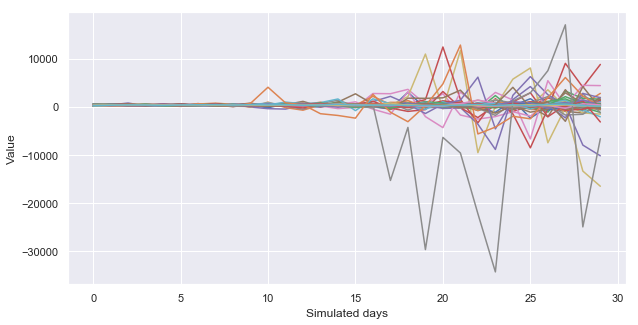

In [78]:
plt.figure(figsize=(10,5))
plt.plot(results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()